In [6]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import losses
from keras.datasets import mnist
import numpy as np
import numpy as np
from tensorflow import keras


In [7]:
batch_size = 100
original_dim = 28*28
latent_dim = 2
intermediate_dim = 256
nb_epoch = 5
epsilon_std = 1.0

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
import tensorflow as tf
from tensorflow import keras

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class CustomDecoder(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(CustomDecoder, self).__init__(**kwargs)
        self.output_dim = output_dim

    def call(self, inputs):
        return tf.math.sigmoid(tf.keras.layers.Dense(self.output_dim)(inputs))


In [18]:
# Define the encoder
encoder_inputs = keras.layers.Input(shape=(original_dim,))
z_mean = keras.layers.Dense(latent_dim, name="mean")(encoder_inputs)
z_log_var = keras.layers.Dense(latent_dim, name="log_var")(encoder_inputs)
z = Sampling()([z_mean, z_log_var])  # Use the custom Sampling layer

# Define the decoder
decoder_inputs = keras.layers.Input(shape=(latent_dim,))
decoder_outputs = CustomDecoder(original_dim)(decoder_inputs)  # Use the custom CustomDecoder layer

# Create the encoder and decoder models
encoder = keras.models.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var, z], name="encoder")
decoder = keras.models.Model(inputs=decoder_inputs, outputs=decoder_outputs, name="decoder")
z_decoded = decoder(z)

class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_mean), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x


# Create the VAE model

vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.models.Model(inputs=encoder_inputs, outputs=vae_outputs, name="vae")


In [19]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               3140      
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               0         
                                                                 
Total params: 3140 (12.27 KB)
Trainable params: 3140 (12.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
def vae_loss(x , x_decoded_mean, z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * losses.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [21]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [14]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [15]:
import tensorflow as tf

In [22]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test),verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 32us/sample - loss: 543.7991 - val_loss: 543.7578
Epoch 2/5
60000/60000 [==============================] - 2s 25us/sample - loss: 543.7681 - val_loss: 543.7590
Epoch 3/5
60000/60000 [==============================] - 2s 27us/sample - loss: 543.7642 - val_loss: 543.7595
Epoch 4/5
60000/60000 [==============================] - 2s 26us/sample - loss: 543.7625 - val_loss: 543.7462
Epoch 5/5
60000/60000 [==============================] - 2s 26us/sample - loss: 543.7590 - val_loss: 543.7557


In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution

In [ ]:
disable_eager_execution()

In [27]:
x_train[1].shape

(784,)

C:\Users\amade\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


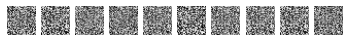

In [30]:
import numpy as np

# Generate random points (e.g., 10 points) in the latent space
latent_points = encoder.predict(x_train[:10])
reconstructed_images = decoder.predict(latent_points)
reconstructed_images = decoder.predict(latent_points)
import matplotlib.pyplot as plt

# Display the reconstructed images
for i in range(len(reconstructed_images)):
    plt.subplot(1, 10, i + 1)
    plt.imshow(reconstructed_images[i].reshape((28,28)), cmap='gray')
    plt.axis('off')

plt.show()



